In [10]:
# imports: 
import pandas as pd
import random
from pydub import AudioSegment
from pydub.playback import play
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import torchaudio
import torch 

# workspace folder:
direct = "E:/archive/waveformOutputs/"

# data folder:
data_dir = "E:/archive/"

#audio folder:
directToAudio = "E:/archive/test_of_data/"

# output folder
savedir = "E:/archive/waveformOutputs/"

# 1. Explore the dataset through code
## a. How many samples does the dataset contain?

In [11]:

metadata_file = "metadata_compiled.csv"
metadata=pd.read_csv(data_dir+metadata_file,sep=",")
#print(metadata.columns)
num_samples = metadata.shape[0]
print("Number of samples:", num_samples)
#metadata

Number of samples: 27550


## b. How many classes? How many samples per class? Show a histogram of the number of instances per class

status
healthy        12479
symptomatic     2590
COVID-19        1155
Name: count, dtype: int64
16224


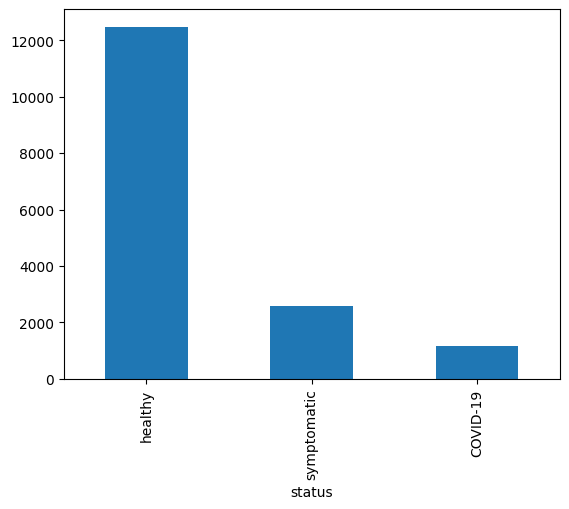

In [12]:
Histogram = metadata['status'].value_counts().plot.bar()
fig = Histogram.get_figure()
print(metadata['status'].value_counts())
print(metadata['status'].dropna().shape[0])

There are three classes: healthy (12479 samples), symptomatic (2590 samples), Covid-19 (1155 samples). 

In [13]:
# Initialize testwav as an empty list
testwav = []

# ...
random.seed(40)
random_samples = metadata.groupby('status').apply(lambda x: x.sample(1))
random_samples = random_samples.reset_index(drop=True)
random_samples = random_samples[['uuid','status']]
print(" ----- PLAYING FOLLOWING HITS: ----- ")
print(random_samples)

for i in range(random_samples.shape[0]):
    uuid = random_samples.loc[i,'uuid']
    status = random_samples.loc[i,'status']
    # print(uuid, status)
    
    # Load the audio file and append it to the list
    audio = AudioSegment.from_file(directToAudio+uuid+".webm",format="webm")
    testwav.append(audio)
    # play(audio)
    
    # Export the audio file
    testwav[-1].export(direct+f"output{status}.wav", format="wav")


 ----- PLAYING FOLLOWING HITS: ----- 
                                   uuid       status
0  e160b3c9-c859-4856-9c2a-23707b65fff9     COVID-19
1  78f090fc-ed2d-4757-880c-4a8c10ea478d      healthy
2  6308bd06-1617-4524-8fc3-b388c2d52499  symptomatic


It is quite complicated to play files through code. But here is the framework of how to. We first convert the data from .webm to .wav, and then use pydub to play it. We don't have permission to use play(audio) though, and it seems like kaggle is using a read-only system. We don't know how to play audio in Kaggle. 

But if done in Python locally, this will create three .wav files from the three randomly chosen .webm files.

### Notes on audio-playback:
Some of the files doesn't contain any cough. Due to this, the data has been labeled by an algorithm for cough-detection. This rates the samples in a Cough-Detection Score (CDS) from 0-1. This will be further commented on under section 1.e.

An alternative to playing the audio is showing the spectograms as done below, where the spectograms of 4 random samples are shown:


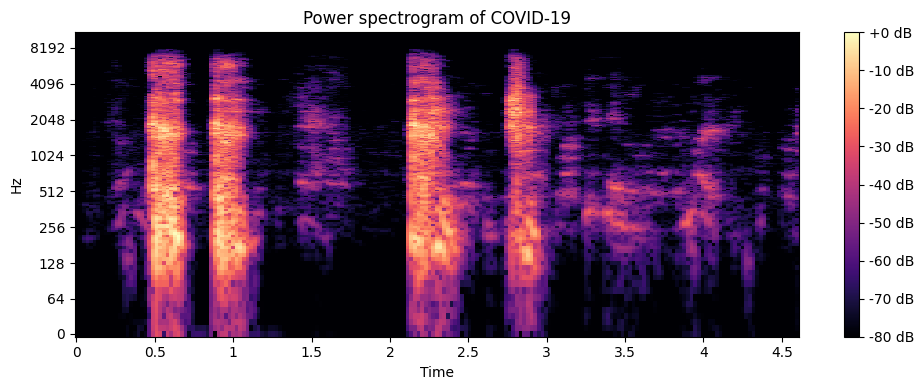

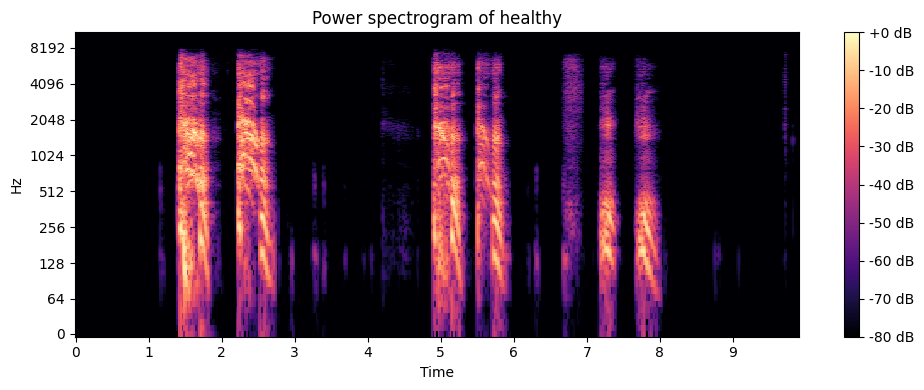

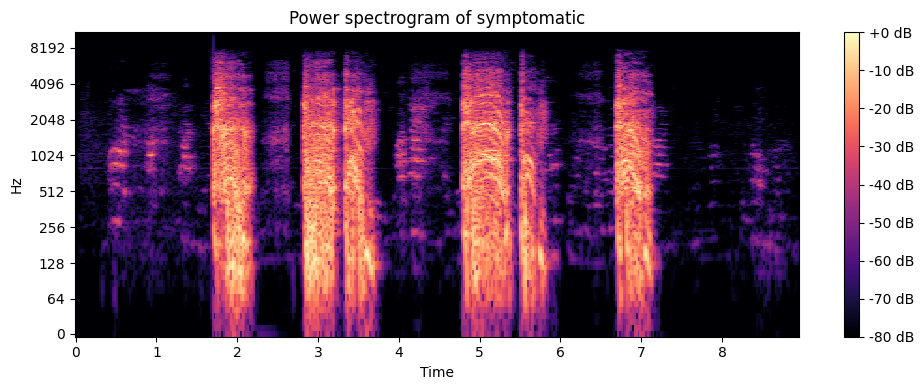

In [14]:
#plot the spectogram of the audio files:
for i in range(len(testwav)):
    plt.figure(figsize=(10, 4))
    y, sr = librosa.load(direct+f"output{random_samples.loc[i,'status']}.wav")
    D = np.abs(librosa.stft(y))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
    plt.title(f'Power spectrogram of {random_samples.loc[i,"status"]}')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(direct+f"spectogram_original_{random_samples.loc[i,'status']}.png")
    plt.show()
    # save figures :
    
    


## d. Describe if/how you think the data distribution will affect training of a classifier.

**1.** We expect that the model will tend towords classifing the cough as healthy due to the prior probability. The dataset right now consists of approximately 80 \% healthy, so always guessing 'healthy' will result in an OK accuracy. \
         **1.2.** This can be countered by over-/under sampling the data. 
         

## e. Decide what part of the dataset to use; all, some classes, some samples. Motivate your choice

We have decided not to use the physician data, as we have seen other working on the same data found this data varying in quality, as can be the case due to the subjectivity of the physician. As this data also requires a physician to obtain will the use of the trained model also require this. making the model less practical.

# Data Augmentation:


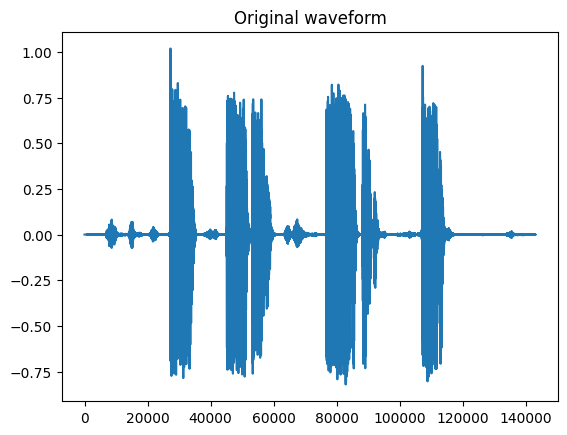

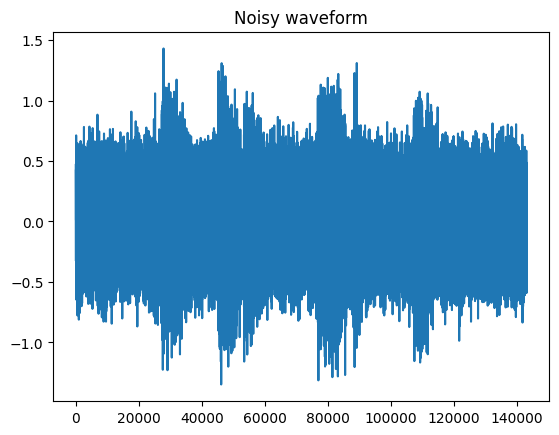

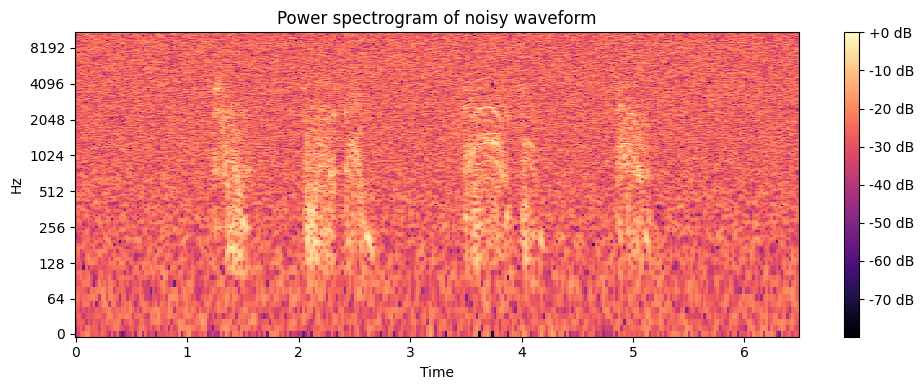

In [15]:
y,sr = torchaudio.load(direct+f"outputhealthy.wav")
if sr != 16000:
    y = torchaudio.transforms.Resample(sr, 16000)(y)

# creating wgn waveform:
noise = torch.randn(y.shape[1])
noise = noise.unsqueeze(0)

SNR = torch.tensor([-5])

# applying noise to original waveform:
noisy_waveform = torchaudio.functional.add_noise(y, noise, SNR)

# plot original waveform:
plt.figure()
plt.plot(y.t().numpy())
plt.title('Original waveform')
plt.savefig(direct+"waveform_original.png")
plt.show()


#plot noisy waveform:
plt.figure()
plt.plot(noisy_waveform.t().numpy())
plt.title('Noisy waveform')
plt.savefig(direct+"waveform_noisy.png")
plt.show()





#plot the spectogram of the audio files:
plt.figure(figsize=(10, 4))
D = np.abs(librosa.stft(noisy_waveform.numpy().flatten()))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title(f'Power spectrogram of noisy waveform')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.savefig(direct+"spectogram_noisy.png")
plt.show()


# save figures :
# plt.savefig(direct+f"output{random_samples.loc[i,'status']}_noisy.png")

#save the noisy waveform:
torchaudio.save(direct+f"output{random_samples.loc[i,'status']}_noisy.wav", noisy_waveform, 16000)



c:\Users\madsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


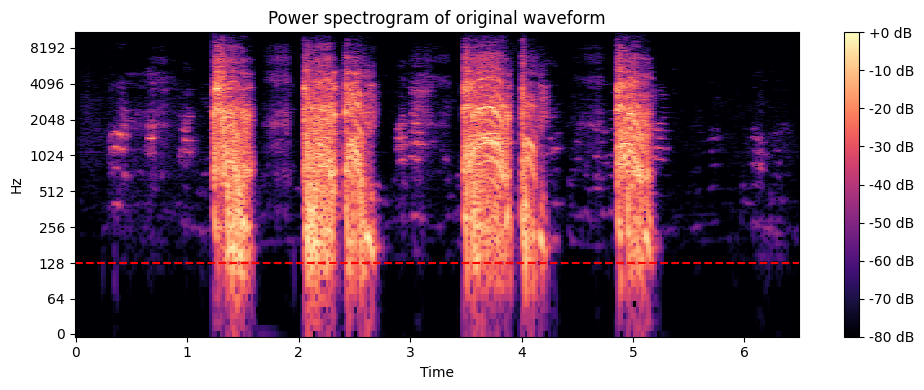

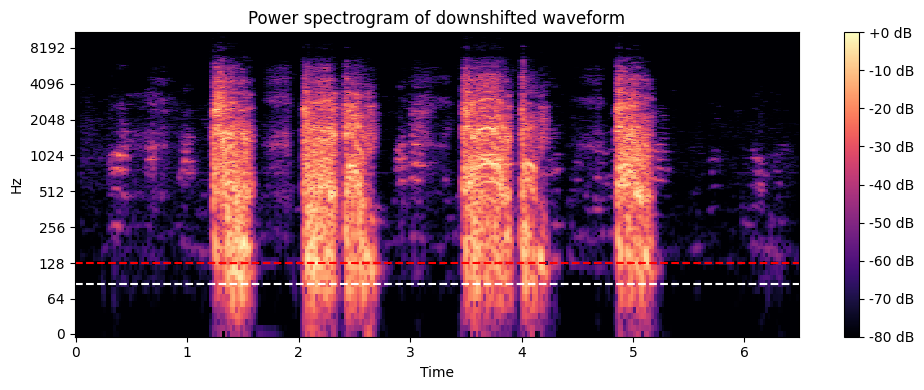

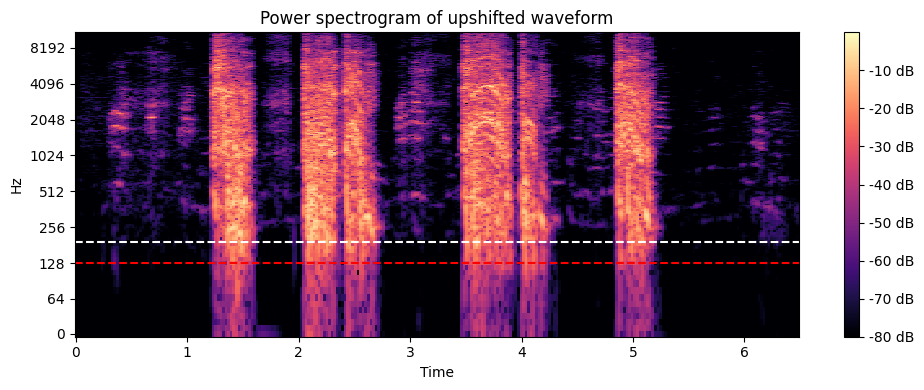

In [16]:
downshifted = torchaudio.transforms.PitchShift(16000, -7)(y)
upshifted = torchaudio.transforms.PitchShift(16000, 7)(y)

#plot y: 
plt.figure(figsize=(10, 4))
D = np.abs(librosa.stft(y.detach().numpy().flatten()))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.axhline(y=128, color='r', linestyle='--')
plt.title(f'Power spectrogram of original waveform')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.savefig(direct+"spectogram_original.png")
plt.show()


#plot the spectogram of the downshifted:
plt.figure(figsize=(10, 4))
D = np.abs(librosa.stft(downshifted.detach().numpy().flatten()))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.axhline(y=128, color='r', linestyle='--')
plt.axhline(y=85.43, color='w', linestyle='--')
plt.title(f'Power spectrogram of downshifted waveform')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.savefig(direct+"spectogram_downshifted.png")
plt.show()



#save downshifted audio:
torchaudio.save(direct+f"output{random_samples.loc[i,'status']}_downshifted.wav", downshifted.detach(), 16000)

#plot the spectogram of the upshifted:
plt.figure(figsize=(10, 4))
D = np.abs(librosa.stft(upshifted.detach().numpy().flatten()))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.axhline(y=128, color='r', linestyle='--')
plt.axhline(y=191.78, color='w', linestyle='--')
plt.title(f'Power spectrogram of upshifted waveform')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.savefig(direct+"spectogram_upshifted.png")
plt.show()


torchaudio.save(direct+f"output{random_samples.loc[i,'status']}_upshifted.wav", upshifted.detach(), 16000)



